### Summary of the analysis

It has been demonstrated before, that modeled networks based on axo-dendritic touch generate a highly non-random structure that matches biological characteristics better than simpler, connection probability-based models. Such characteristics are for example degree distributions, and motif overexpression patterns.

We formulate a hypothesis of what mechanism leads to this and test it using the MICrONS data. The hypothesis is as follows:

  1. A required (although not sufficient) condition for the formation of a connection is proximity of the axon to the dendrite
  2. This condition can in principle be formulated as a distance and direction-dependent probability function on the offset between somata of a neuron pair. 
  3. The shape of this function is determined by the overall average shape of the dendrites and axons of the classes of neurons considered.
  4. However, once a connection at a given distance and direction has been confirmed for a given pre-/post-synaptic neuron, this function must be updated for all its future potential connections. This is because presence of the connection demonstrates that the axon / dendrites are more likely to be oriented towards the point where the connection has been formed.
  5. On a theoretical level, this introduces a _statistical dependence_ between connections: Presence or absence of one connection influences the probability that another connection is present. This is something that connection probability-dependent models, even complex ones, cannot capture, as they are based on statistically independent evaluations of connection probabilities.

We consider points 1-3 to be widely accepted. Points 4 and 5 describe aplausible scenario. But we have to demonstrate that the proposed mechanism actually affects connectivity on a measurable level. To do so, we test a prediction derived from the hypothesis.

**Prediction**: If a neuron A innervates / is innervated by a neuron B, then the probability that it also innervates / is innervated by the _nearest spatial neighbor_ of B is increased.

## Importing code libraries and loading the data

We import a number of standard packages, as well as _conntility_. These two packages provide (as we will see) useful functionality for the analysis of this type of data.

In [ ]:
import conntility
import pandas
import numpy

from scipy.stats import binom
from matplotlib import pyplot as plt
from ipywidgets import Dropdown, SelectMultiple

numpy.seterr(all="ignore")


# Obtain the file at https://doi.org/10.5281/zenodo.16744240 (MICrONS)
# or at https://doi.org/10.5281/zenodo.16744766 (Potential connectivity of an SSCX model)
#
# Note: the MICrONS data is based on version 1412 of MICrONs, while many of the other notebooks in this 
# repository use version 1181. In principle, you can also also run this notebook for version 1181.
# However, you will have to make one small change: The version 1181 provides neuron locations only 
# in nm, not in um. Additionally, a pre-calculated distance-dependent control is only available for
# version 1412.
fn = "microns_mm3_connectome_v1412.h5"


# We load the data that has been serialized into a single hdf5 file into an object.
M = conntility.ConnectivityMatrix.from_h5(fn, "condensed")


## Select the excitatory sub-graph

It is quite accepted that connectivity of inhibitory neurons follows quite different rules than excitatory connectivity. 
Hence, we limit our analysis here to only the excitatory subgraph, for simplicity.


In [110]:
# Create a subcircuit using the .index functionality. The following creates the subcircuit of neurons where 
# the values of "synapse_class" is equal to "EXC".
M = M.index("classification_system").eq("excitatory_neuron")

## Select a trustworthy subset of neurons

Some datasets (e.g., EM connectomes) require proofreading to provide trustworthy connectivity data.
Here, we will build up two separate filters that determine whether we consider a neuron to have trustworthy outgoing and incoming connectivity data

### Neurons to consider for outgoing connectivity

In the following dropdown, please select a vertex (neuron) property that will serve as the basis for a filter. The filter will be used to determine neurons with trustworthy *outgoing* connectivity.

**Hint**: For MICrONS EM connectome data, use "status_axon". The rationale is, that we consider a neurons outgoing connectivity only if the *axon* has been proofread. For data from computational models filtering is not required. Therefore, you can leave the dropdown at "*no filtering*".

In [111]:
no_fltr = "No filtering"
select_fltr_row = Dropdown(options=[no_fltr, *M.vertex_properties],
                           description="OUTGOING")
display(select_fltr_row)

Dropdown(description='OUTGOING', options=('No filtering', 'layer', 'mtype', 'pt_root_id', 'volume', 'pt_superv…

Next, select all possible values of the selected neuron property that indicate a *trustworthy* neuron, i.e., a neuron that we **do** want to consider for outgoing connectivity.

**Hint**: For MICrONS and "status_axon", select "t"

If "No filtering" was selected, nothing will be displayed.

In [112]:
select_vals_row = None
if select_fltr_row.value != no_fltr:
    v = M.vertices[select_fltr_row.value].drop_duplicates()
    if len(v) > 20:
        raise ValueError(f"Property {select_fltr_row.value} has too many unique values. Please select a categorical property!")
    select_vals_row = SelectMultiple(options=v, description="Valid values")
    display(select_vals_row)

SelectMultiple(description='Valid values', options=('empty', 't', 'f'), value=())

### Neurons to consider for incoming connectivity

We repeat the same filter setup process for the **incoming** connectivity. 
What is required to consider a neuron's incoming connectivity trustworthy?

In [113]:
select_fltr_col = Dropdown(options=[no_fltr, *M.vertex_properties],
                           description="INCOMING")
display(select_fltr_col)

Dropdown(description='INCOMING', options=('No filtering', 'layer', 'mtype', 'pt_root_id', 'volume', 'pt_superv…

In [114]:
select_vals_col = None
if select_fltr_col.value != no_fltr:
    v = M.vertices[select_fltr_col.value].drop_duplicates()
    if len(v) > 20:
        raise ValueError(f"Property {select_fltr_col.value} has too many unique values. Please select a categorical property!")
    select_vals_col = SelectMultiple(options=v, description="Valid values")
    display(select_vals_col)

Now we assemble the filters according to these specs and get the indices of rows and columns of the matrix that we want to consider.

In [115]:
index_row = M.vertices.index
if select_vals_row is not None:
    index_row = index_row[M.vertices.loc[index_row, select_fltr_row.value].isin(select_vals_row.value)]

index_col = M.vertices.index
if select_vals_col is not None:
    index_col = index_col[M.vertices.loc[index_col, select_fltr_col.value].isin(select_vals_col.values)]

print(f"Considering {len(index_row)} neurons for outgoing, {len(index_col)} neurons for incoming connectivity!")

Considering 1680 neurons for outgoing, 45598 neurons for incoming connectivity!


## Finding the nearest neighbors
To find the nearest neighbors of each neuron, we use a specialized data structure called a KDTree, implemented in scipy. It takes as input the spatial coordinates (i.e., the "x", "y" and "z" properties) of all neurons.

Specifically, we build a numpy.array with one entry per neuron, where the entry at index i yields the index of the nearest neighbor of the ith neuron.

In [116]:
from scipy.spatial import KDTree

xyz = ["x", "y", "z"]
# Build KDTree
tree_full = KDTree(M.vertices[xyz])
# We also build KDTrees for only the "trustworthy" populations. They will be used later.
tree_f_row = KDTree(M.vertices.loc[index_row, xyz])
tree_f_col = KDTree(M.vertices.loc[index_col, xyz])

# Query KDTree for nearest neighbor. [2] indicates we ask for the 2nd nearest neighbor. This is, because the neuron itself
# is not excluded from this query and will be the 1st nearest neighbor with a distance of 0
nn_dists, nn_idx = tree_full.query(M.vertices[xyz], [2])
nn_idx = nn_idx.flatten()


### Small detour: plot nearest neighbor distances

Just as a quick sanity check and out of curiosity, we plot a histogram of the distances to the nearest neighbor of each neuron

Text(0, 0.5, 'Count')

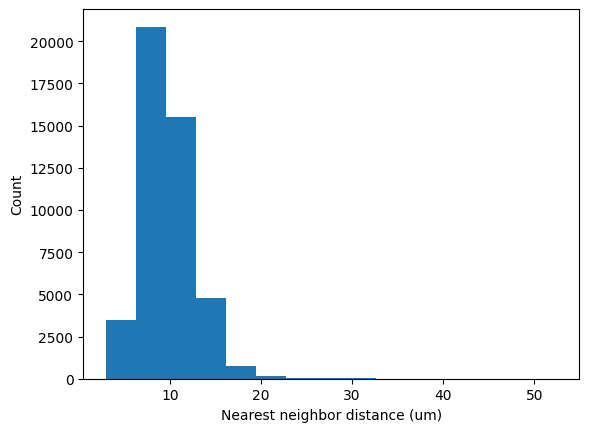

In [117]:
H = numpy.histogram(nn_dists, bins=15)
plt.bar(H[1][:-1], H[0], width=numpy.mean(numpy.diff(H[1])))
plt.gca().set_xlabel("Nearest neighbor distance (um)")
plt.gca().set_ylabel("Count")

# Main analysis

Now, we perform the main analysis. 
As we have ~50,000 neurons in the dataset, we have ~2,500,000,000 pairs of potentially connected neurons. While it is still viable to iterate in analyses over that number of pairs, it is also highly inefficient. 

Instead, I will implement a more efficient form of the analysis.

We begin by assembling a DataFrame with one row per **connected** pair. Its columns are as follows:
  - "row": Index of the pre-synaptic neuron of the connection
  - "col": Index of the post-synaptic neuron of the connection
  - "nn_row": Index of the nearest neighbor of the pre-synaptic neuron
  - "mask_nn_row": Is `True` if the neuron at `nn_row` is trustworthy for outgoing connectivity
  - "nn_col": Index of the nearest neighbor of the post-synaptic neuron
  - "mask_nn_col": Is `True` if the neuron at `nn_col` is trustworthy for incoming connectivity
  - "dx", "dy", "dz": Offset along the spatial axes of the pair locations.
  - "1d_dist": Distance (1-dimensional) of between the neurons of the pair

In [157]:
def make_edge_df(M, apply_filtering=True):
    # columns "row", and "col" are already part of the data structure we loaded inititally. 
    edge_df = M._edge_indices.copy().reset_index(drop=True)

    # We can then look up "nn_row", "nn_col" from the array we assembled earlier
    edge_df["nn_col"] = nn_idx[M._edge_indices["col"]]
    edge_df["nn_row"] = nn_idx[M._edge_indices["row"]]

    # We only consider entries that pass our filters we set up above.
    if apply_filtering:
        edge_df = edge_df.loc[edge_df["row"].isin(index_row) & edge_df["col"].isin(index_col)]

    # For some analyses more specific masks are needed: Do the various nn_row / nn_col entries pass the filters?
    edge_df["mask_nn_row"] = edge_df["nn_row"].isin(index_row)
    edge_df["mask_nn_col"] = edge_df["nn_col"].isin(index_col)

    # M provides a function that yields for each connection the "x", "y" or "z" coordinate of the pre- and post-syn. neurons
    # We calculate their distances as "dx", "dy", "dz"
    for col_name in xyz:
        per_edge_coords = M.edge_associated_vertex_properties(col_name)
        edge_df["d" + col_name] = per_edge_coords["col"] - per_edge_coords["row"]

    # 1-dimensional distance is easily calculated
    xyz_delta = ["dx", "dy", "dz"]
    edge_df["1d_dist"] = numpy.linalg.norm(edge_df[xyz_delta], axis=1)
    return edge_df

edge_df = make_edge_df(M)
display(edge_df.head())


,row,col,nn_col,nn_row,mask_nn_row,mask_nn_col,dx,dy,dz,1d_dist
3903,80,2,110,82,False,True,11.968,-11.968,-58.44,60.841595
3904,80,50,219,82,False,True,-47.936,-25.792,-76.24,93.678306
3905,80,65,63,82,False,True,-15.168,22.592,3.32,27.413301
3906,80,87,1009,82,False,True,9.536,-38.272,1.56,39.472964
3907,80,112,113,82,False,True,8.384,16.064,-37.52,41.666461


This allows us to easily look up connection probabilities from the adjacency matrix

In [158]:
# Adjacency matrix. Efficiently represented as a sparse matrix with bool entries
actual_con = M.matrix.tocsc().astype(bool)

# Note that each row of the DataFrame represents one instance where the nearest neighbor of neuron B is connected to A.
# Hence, we can use to easily look up the probability that B is also connected to A.
prior_f_mean = actual_con[numpy.ix_(index_row, index_col)].mean()
post_nn_con_mean = actual_con[edge_df["row"], edge_df["nn_col"]].mean()
mask = edge_df["mask_nn_col"]
post_nn_con_f_mean = actual_con[edge_df.loc[mask, "row"], edge_df.loc[mask, "nn_col"]].mean()
pre_nn_con_mean = actual_con[edge_df["nn_row"], edge_df["col"]].mean()
mask = edge_df["mask_nn_row"]
pre_nn_con_f_mean = actual_con[edge_df.loc[mask, "nn_row"], edge_df.loc[mask, "col"]].mean()

print(f"""Overall connection probability: {actual_con.mean()},
            For filtered neurons: {prior_f_mean},
      If post-synaptic nearest neighbor is connected: {post_nn_con_mean},
            For filtered neurons: {post_nn_con_f_mean},
      if pre-synaptic nearest neighbor is connected: {pre_nn_con_mean},
            For filtered neurons: {pre_nn_con_f_mean}""")

Overall connection probability: 0.001463764804961799,
            For filtered neurons: 0.004866506780790301,
      If post-synaptic nearest neighbor is connected: 0.05273647588365786,
            For filtered neurons: 0.05273647588365786,
      if pre-synaptic nearest neighbor is connected: 0.023178834593626022,
            For filtered neurons: 0.0316066280429957


We see that the connection probability is drastically increased, especially if the post-synaptic nearest neighbor is connected.

However, distance-dependence of connectivity can explain (part of) such an effect: The nearest neighbor being connected makes it likely that we are considering a pair of neurons at a low distance. That also increases the probability that the original neuron is connected.

## Loading a distance-dependent control

To address this, we begin by creating a distance-dependent control connectome. Specifically, we consider the following: For each ordered pair of layers, (L_i, L_j) we fit an exponential function that describes the connection probability from neurons in L_i to neurons in L_j. Then we generate a stochastic instance of that connectome.

The fitting would take around 3-5 minutes to run. To speed things up, we have prepared such a control connectome and we simply load it. 
**Imortantly**, the control connectome was generated on the same nodes with the same locations as the original connectome. So we do not have to re-generate the lookup for nearest neighbors.

**Note**: Since this is an algorithmically-generated control, all connections are trustworthy and we do not consider the filtering.

In [ ]:
# Obtain the file at https://doi.org/10.5281/zenodo.16744240
fn_ctrl = "microns_mm3_v1412_distance_dependent_control.h5"

C = conntility.ConnectivityMatrix.from_h5(fn_ctrl)

# Make sure the neuron locations really are identical
assert (M.vertices[xyz] == C.vertices[xyz]).all().all()
# Sparse adjacency matrix
control_con = C.matrix.tocsc().astype(bool)
edge_df_ctrl = make_edge_df(C, apply_filtering=False)

post_nn_con_mean = control_con[edge_df_ctrl["row"], edge_df_ctrl["nn_col"]].mean()
pre_nn_con_mean = control_con[edge_df_ctrl["nn_row"], edge_df_ctrl["col"]].mean()

print(f"""Overall connection probability: {control_con.mean()},
      If post-synaptic nearest neighbor is connected: {post_nn_con_mean},
      if pre-synaptic nearest neighbor is connected: {pre_nn_con_mean}""")

Overall connection probability: 0.0014608819343554262,
      If post-synaptic nearest neighbor is connected: 0.008568419451556626,
      if pre-synaptic nearest neighbor is connected: 0.008562822620284958


We see that there is indeed an effect in the distance-dependent control. However, it is sgnificantly weaker than in the actual data.

## Making the analysis distance-dependent
To control for the effect of distance dependence even further, we repeat the analysis, but separately in 50 um distance bins.

To that end, we first need to generate the bins and calculate how many pairs of neurons there are in each bin. Once again, this is valid for both the original data and the control.

For this, we use the two KDTrees that represent the trustworthy pre- and post-synaptic populations that we created earlier.

**Note**: This means that the resulting `n_pairs_per_bin` represents the number of pairs at a given distance bin where one neuron is in the population for trustworthy outgoing and the other in the population for trustworty incoming connectivity.

In [159]:
# Set up bins
bin_sz = 25.0
# We create the last bin border at a really large distance to ensure that the last bin captures any remaining pair
bin_borders = numpy.hstack([numpy.arange(0, 1000 + bin_sz, bin_sz), 1E12])
bin_indices = numpy.arange(len(bin_borders) - 1)
# Calculate bin centers. For plotting purporses we consider the really large last bin to be "bin_sz" distance away from the previous.
bin_centers = 0.5 * (bin_borders[:-2] + bin_borders[1:-1])
bin_centers = numpy.hstack([bin_centers, bin_centers[-1] + bin_sz])

# For each connected pair, we calculate which distance bin it belongs to
edge_df["1d_dist_bin"] = numpy.digitize(edge_df["1d_dist"], bins=bin_borders) - 1

# The "count_neighbors" function yields the numbers of pairs at distances up to and including the queried distance. 
# That is, it is a cumulative count. We take the .diff to get the non-cumulative numbers in each bin.
n_pairs_per_bin = numpy.diff(tree_f_col.count_neighbors(tree_f_row, bin_borders))


Main analysis:
We compare the overall connection probabilities to the conditional connection probabilities if the nearest neighbor of the partner neuron is confirmed to be connected.

*Formally*

Let `->` indicate that we measure the probability that an edge in the indicated direction exists, and "->" indicate that an edge in the indicated direction is confirmed to exist.

*Overall probability*: 
The probability that A `->` B, given that:
  - D(A, B) falls into the indicated distance bin
  - A is trustworthy for outgoing connectivity
  - B is trustworthy for incoming connectivity

*If postsyn NN connected*: 
The probability that A `->` B, given that:
  - D(A, B) falls into the indicated distance bin
  - A is trustworthy for outgoing connectivity
  - B is trustworthy for incoming connectivity
  - C = NN(B) is trustworthy for incoming connectivity
  - A "->" C

*If presyn NN connected*: 
The probability that A `->` B, given that:
  - D(A, B) falls into the indicated distance bin
  - A is trustworthy for outgoing connectivity
  - B is trustworthy for incoming connectivity
  - C = NN(A) is trustworthy for outgoing connectivity
  - C "->" B


Because this makes it hard to intuit how many pairs are actually considered for the calculation of a probability, we also indicate in a smaller plot the number of pairs considered.

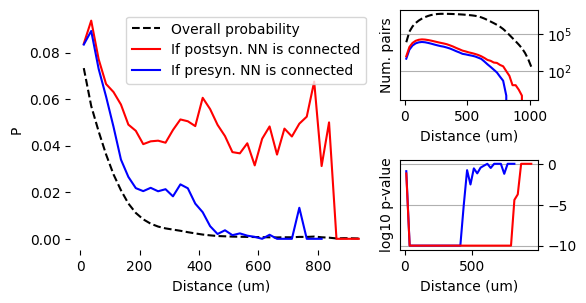

In [ ]:
fig = plt.figure(figsize=(5.5, 3))
ax = fig.add_axes([0.1, 0.1, 0.55, 0.8])

prior_con_prob = edge_df.groupby("1d_dist_bin")["1d_dist_bin"].count().reindex(bin_indices) / n_pairs_per_bin

mask = edge_df["mask_nn_col"]
con_prob_post_is_connected = edge_df.loc[mask].groupby("1d_dist_bin").apply(lambda _df: actual_con[_df["row"], _df["nn_col"]].mean(),
                                                                            include_groups=False)
n_smpls_post_is_connected = edge_df.loc[mask]["1d_dist_bin"].value_counts().reindex(bin_indices, fill_value=0)
mask = edge_df["mask_nn_row"]
con_prob_pre_is_connected = edge_df.loc[mask].groupby("1d_dist_bin").apply(lambda _df: actual_con[_df["nn_row"], _df["col"]].mean(),
                                                                  include_groups=False)
n_smpls_pre_is_connected = edge_df.loc[mask]["1d_dist_bin"].value_counts().reindex(bin_indices, fill_value=0)

# significance: Using a binomial distribution on the prior connection probability as null-hypothesis
# One-tailed: Probability to find the given number of connections or even more
null_distr = binom(n_smpls_post_is_connected, prior_con_prob)
p_values_post_is_connected = 1.0 - null_distr.cdf(n_smpls_post_is_connected * con_prob_post_is_connected - 1)
null_distr = binom(n_smpls_pre_is_connected, prior_con_prob)
p_values_pre_is_connected = 1.0 - null_distr.cdf(n_smpls_pre_is_connected * con_prob_pre_is_connected - 1)


ax.plot(bin_centers[prior_con_prob.index], prior_con_prob, color="black", ls="--", label="Overall probability")

ax.plot(bin_centers[con_prob_post_is_connected.index], con_prob_post_is_connected, color="red", label="If postsyn. NN is connected")
ax.plot(bin_centers[con_prob_pre_is_connected.index], con_prob_pre_is_connected, color="blue", label="If presyn. NN is connected")
plt.legend()
ax.set_xlabel("Distance (um)")
ax.set_ylabel("P")
ax.set_frame_on(False)

ax = fig.add_axes([0.7, 0.6, 0.25, 0.3])
ax.yaxis.tick_right()
ax.plot(bin_centers, n_pairs_per_bin, ls="--", color="black")
ax.plot(bin_centers[n_smpls_pre_is_connected.index], n_smpls_pre_is_connected, color="blue")
ax.plot(bin_centers[n_smpls_post_is_connected.index], n_smpls_post_is_connected, color="red")
ax.set_yscale("log")
plt.grid(axis="y")
ax.set_xlabel("Distance (um)")
ax.set_ylabel("Num. pairs")

ax = fig.add_axes([0.7, 0.1, 0.25, 0.3])
min_log10_p_indicated = -10
log_p_pre_is_connected = numpy.log10(p_values_pre_is_connected)
log_p_pre_is_connected[(log_p_pre_is_connected < min_log10_p_indicated) | (p_values_pre_is_connected == 0)] = min_log10_p_indicated
log_p_post_is_connected = numpy.log10(p_values_post_is_connected)
log_p_post_is_connected[(log_p_post_is_connected < min_log10_p_indicated) | (p_values_post_is_connected == 0)] = min_log10_p_indicated
ax.yaxis.tick_right()
ax.plot(bin_centers, log_p_pre_is_connected, color="blue")
ax.plot(bin_centers, log_p_post_is_connected, color="red")
plt.grid(axis="y")
ax.set_xlabel("Distance (um)")
ax.set_ylabel("log10 p-value")
ax.set_ylim([-10.5, 0.5])


Once again, we find a very strong effect. Especially if the post-synaptic neighbor is connected.

We repeat the same analysis for the distance-dependent control.

Here, we also apply the same filtering based on "trustworthyness" as in the analysis above. This is not required, as the control connectome is algorithmically generated and thus every connecton is equally "trustworthy". But this way, it also serves as a control of the potential effects of subsampling.

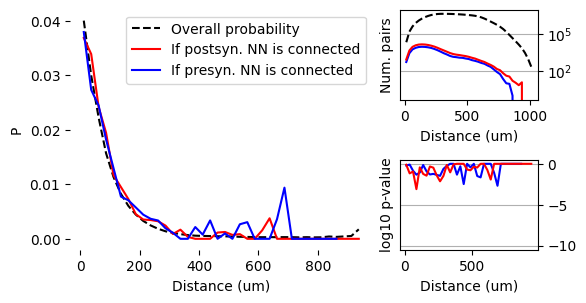

In [ ]:
fig = plt.figure(figsize=(5.5, 3))
ax = fig.add_axes([0.1, 0.1, 0.55, 0.8])

edge_df_ctrl = make_edge_df(C, apply_filtering=True)
edge_df_ctrl["1d_dist_bin"] = numpy.digitize(edge_df_ctrl["1d_dist"], bins=bin_borders) - 1


ctrl_prior_con_prob = edge_df_ctrl.groupby("1d_dist_bin")["1d_dist_bin"].count().reindex(bin_indices) / n_pairs_per_bin

mask = edge_df_ctrl["mask_nn_col"]
ctrl_con_prob_post_is_connected = edge_df_ctrl.loc[mask].groupby("1d_dist_bin").apply(lambda _df: control_con[_df["row"], _df["nn_col"]].mean(),
                                                                  include_groups=False)
ctrl_smpls_post_is_connected = edge_df_ctrl.loc[mask]["1d_dist_bin"].value_counts().reindex(bin_indices, fill_value=0)

mask = edge_df_ctrl["mask_nn_row"]
ctrl_con_prob_pre_is_connected = edge_df_ctrl.loc[mask].groupby("1d_dist_bin").apply(lambda _df: control_con[_df["nn_row"], _df["col"]].mean(),
                                                                  include_groups=False)
ctrl_smpls_pre_is_connected = edge_df_ctrl.loc[mask]["1d_dist_bin"].value_counts().reindex(bin_indices, fill_value=0)

# significance
null_distr = binom(ctrl_smpls_post_is_connected, ctrl_prior_con_prob)
p_values_post_ctrl = 1.0 - null_distr.cdf(ctrl_smpls_post_is_connected * ctrl_con_prob_post_is_connected - 1)
null_distr = binom(ctrl_smpls_pre_is_connected, ctrl_prior_con_prob)
p_values_pre_ctrl = 1.0 - null_distr.cdf(ctrl_smpls_pre_is_connected * ctrl_con_prob_pre_is_connected - 1)


ax.plot(bin_centers[ctrl_prior_con_prob.index], ctrl_prior_con_prob, color="black", ls="--", label="Overall probability")

ax.plot(bin_centers[ctrl_con_prob_post_is_connected.index], ctrl_con_prob_post_is_connected, color="red", label="If postsyn. NN is connected")
ax.plot(bin_centers[ctrl_con_prob_pre_is_connected.index], ctrl_con_prob_pre_is_connected, color="blue", label="If presyn. NN is connected")
plt.legend()
ax.set_xlabel("Distance (um)")
ax.set_ylabel("P")
ax.set_frame_on(False)

ax = fig.add_axes([0.7, 0.6, 0.25, 0.3])
ax.yaxis.tick_right()
ax.plot(bin_centers, n_pairs_per_bin, ls="--", color="black")
ax.plot(bin_centers[ctrl_smpls_pre_is_connected.index], ctrl_smpls_pre_is_connected, color="blue")
ax.plot(bin_centers[ctrl_smpls_post_is_connected.index], ctrl_smpls_post_is_connected, color="red")
ax.set_yscale("log")
plt.grid(axis="y")
ax.set_xlabel("Distance (um)")
ax.set_ylabel("Num. pairs")

ax = fig.add_axes([0.7, 0.1, 0.25, 0.3])
min_log10_p_indicated = -10
log_p_pre_is_connected = numpy.log10(p_values_pre_ctrl)
log_p_pre_is_connected[(log_p_pre_is_connected < min_log10_p_indicated) | (p_values_pre_ctrl == 0)] = min_log10_p_indicated
log_p_post_is_connected = numpy.log10(p_values_post_ctrl)
log_p_post_is_connected[(log_p_post_is_connected < min_log10_p_indicated) | (p_values_post_ctrl == 0)] = min_log10_p_indicated
ax.yaxis.tick_right()
ax.plot(bin_centers, log_p_pre_is_connected, color="blue")
ax.plot(bin_centers, log_p_post_is_connected, color="red")
plt.grid(axis="y")
ax.set_xlabel("Distance (um)")
ax.set_ylabel("log10 p-value")
ax.set_ylim([-10.5, 0.5])


No effect here!